In [1]:
%matplotlib inline
from gluoncv.data import VOCDetection

Dataset
-------

Please first go through this `sphx_glr_build_examples_datasets_pascal_voc.py` tutorial to setup Pascal
VOC dataset on your disk.
Then, we are ready to load training and validation images.



In [2]:
root = 'E:/Data/VOC/VOCdevkit'
# typically we use 2007+2012 trainval splits for training data
train_dataset = VOCDetection(root, splits=[(2007, 'trainval'), (2012, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(root, splits=[(2007, 'test')])

print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 16551
Validation images: 4952


Data transform
--------------
We can read an image-label pair from the training dataset:



In [5]:
train_image, train_label = train_dataset[6]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (375, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


Plot the image, together with the bounding box labels:



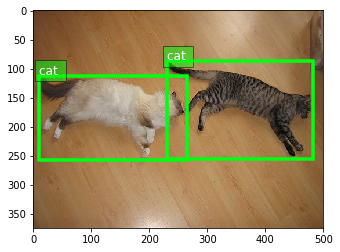

In [6]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

Validation images are quite similar to training because they were
basically split randomly to different sets



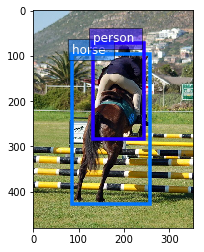

In [8]:
val_image, val_label = val_dataset[6]
bboxes = val_label[:, :4]
cids = val_label[:, 4:5]
ax = viz.plot_bbox(val_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

For Faster-RCNN networks, the only data augmentation is horizontal flip.



In [9]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [10]:
short, max_size = 600, 1000  # resize image to short side 600 px, but keep maximum length within 1000
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size)
val_transform = presets.rcnn.FasterRCNNDefaultValTransform(short, max_size)

In [11]:
utils.random.seed(233)  # fix seed in this tutorial

We apply transforms to train image



In [12]:
train_image2, train_label2 = train_transform(train_image, train_label)
print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)

tensor shape: (3, 600, 800)
box and id shape: (2, 6)


Images in tensor are distorted because they no longer sit in (0, 255) range.
Let's convert them back so we can see them clearly.



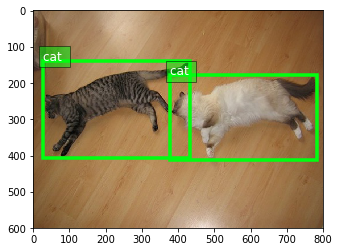

In [13]:
train_image2 = train_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255).asnumpy().astype('uint8')
ax = viz.plot_bbox(train_image2, train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

Data Loader
-----------
We will iterate through the entire dataset many times during training.
Keep in mind that raw images have to be transformed to tensors
(mxnet uses BCHW format) before they are fed into neural networks.

A handy DataLoader would be very convenient for us to apply different transforms and aggregate data into mini-batches.

Because Faster-RCNN handles raw images with various aspect ratios and various shapes, we provide a
:py:class:`gluoncv.data.batchify.Append`, which neither stack or pad images, but instead return lists.
In such way, image tensors and labels returned have their own shapes, unaware of the rest in the same batch.



In [14]:
from gluoncv.data.batchify import Tuple, Append
from mxnet.gluon.data import DataLoader

batch_size = 2  # for tutorial, we use smaller batch-size
num_workers = 0  # you can make it larger(if your CPU has more cores) to accelerate data loading

# behavior of batchify_fn: stack images, and pad labels
batchify_fn = Tuple(Append(), Append())
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                        batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)
    print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape)

data 0: (1, 3, 600, 800) label 0: (1, 5, 6)
data 1: (1, 3, 600, 901) label 1: (1, 9, 6)
data 0: (1, 3, 600, 800) label 0: (1, 2, 6)
data 1: (1, 3, 562, 1000) label 1: (1, 1, 6)
data 0: (1, 3, 600, 904) label 0: (1, 1, 6)
data 1: (1, 3, 600, 888) label 1: (1, 2, 6)
data 0: (1, 3, 600, 901) label 0: (1, 1, 6)
data 1: (1, 3, 600, 901) label 1: (1, 1, 6)


Faster-RCNN Network
-------------------
GluonCV's Faster-RCNN implementation is a composite Gluon HybridBlock :py:class:`gluoncv.model_zoo.FasterRCNN`.
In terms of structure, Faster-RCNN networks are composed of base feature extraction
network, Region Proposal Network(including its own anchor system, proposal generator),
region-aware pooling layers, class predictors and bounding box offset predictors.

`Gluon Model Zoo <../../model_zoo/index.html>`__ has a few built-in Faster-RCNN networks, more on the way.
You can load your favorite one with one simple line of code:

.. hint::

   To avoid downloading model in this tutorial, we set ``pretrained_base=False``,
   in practice we usually want to load pre-trained imagenet models by setting
   ``pretrained_base=True``.



In [15]:
from gluoncv import model_zoo
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained_base=False)
print(net)

FasterRCNN(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BottleneckV1b(
        (conv1): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
        (conv2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
        (conv3): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, 

)


Faster-RCNN network is callable with image tensor



In [16]:
import mxnet as mx
x = mx.nd.zeros(shape=(1, 3, 600, 800))
net.initialize()
cids, scores, bboxes = net(x)

Faster-RCNN returns three values, where ``cids`` are the class labels,
``scores`` are confidence scores of each prediction,
and ``bboxes`` are absolute coordinates of corresponding bounding boxes.



Faster-RCNN network behave differently during training mode:



In [17]:
from mxnet import autograd
with autograd.train_mode():
    # this time we need ground-truth to generate high quality roi proposals during training
    gt_box = mx.nd.zeros(shape=(1, 1, 4))
    cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(x, gt_box)

In training mode, Faster-RCNN returns a lot of intermediate values, which we require to train in an end-to-end flavor,
where ``cls_preds`` are the class predictions prior to softmax,
``box_preds`` are bounding box offsets with one-to-one correspondence to proposals
``roi`` is the proposal candidates, ``samples`` and ``matches`` are the sampling/matching results of RPN anchors.
``rpn_score`` and ``rpn_box`` are the raw outputs from RPN's convolutional layers.
and ``anchors`` are absolute coordinates of corresponding anchors boxes.



Training losses
---------------
There are four losses involved in end-to-end Faster-RCNN training.



In [18]:
# the loss to penalize incorrect foreground/background prediction
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
# the loss to penalize inaccurate anchor boxes
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1/9.)  # == smoothl1
# the loss to penalize incorrect classification prediction.
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
# and finally the loss to penalize inaccurate proposals
rcnn_box_loss = mx.gluon.loss.HuberLoss()  # == smoothl1

RPN training targets
--------------------
To speed up training, we let CPU to pre-compute RPN training targets.
This is especially nice when your CPU is powerful and you can use ``-j num_workers``
to utilize multi-core CPU.



If we provide network to the training transform function, it will compute training targets



In [19]:
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net)
# Return images, labels, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely
batchify_fn = Tuple(*[Append() for _ in range(5)])
# For the next part, we only use batch size 1
batch_size = 1
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

This time we can see the data loader is actually returning the training targets for us.
Then it is very naturally a gluon training loop with Trainer and let it update the weights.



In [20]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # -1 marks ignored label
            print('rpn cls label:', rpn_cls_targets.shape)
            # mask out ignored box label
            print('rpn box label:', rpn_box_targets.shape)
            print('rpn box mask:', rpn_box_masks.shape)

data: (1, 3, 600, 800)
box: (1, 6, 4)
label: (1, 6, 1)
rpn cls label: (1, 28500)
rpn box label: (1, 28500, 4)
rpn box mask: (1, 28500, 4)


RCNN training targets
---------------------
RCNN targets are generated with the intermediate outputs with the stored target generator.



In [ ]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(batch[0][0], gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # rcnn does not have ignored label
            print('rcnn cls label:', cls_targets.shape)
            # mask out ignored box label
            print('rcnn box label:', box_targets.shape)
            print('rcnn box mask:', box_masks.shape)

Training loop
-------------
After we have defined loss function and generated training targets, we can write the training loop.



In [ ]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.record():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(data, gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            # losses of rpn
            rpn_score = rpn_score.squeeze(axis=-1)
            num_rpn_pos = (rpn_cls_targets >= 0).sum()
            rpn_loss1 = rpn_cls_loss(rpn_score, rpn_cls_targets, rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
            rpn_loss2 = rpn_box_loss(rpn_box, rpn_box_targets, rpn_box_masks) * rpn_box.size / num_rpn_pos

            # losses of rcnn
            num_rcnn_pos = (cls_targets >= 0).sum()
            rcnn_loss1 = rcnn_cls_loss(cls_preds, cls_targets, cls_targets >= 0) * cls_targets.size / cls_targets.shape[0] / num_rcnn_pos
            rcnn_loss2 = rcnn_box_loss(box_preds, box_targets, box_masks) * box_preds.size / box_preds.shape[0] / num_rcnn_pos

        # some standard gluon training steps:
        # autograd.backward([rpn_loss1, rpn_loss2, rcnn_loss1, rcnn_loss2])
        # trainer.step(batch_size)